In [3]:
# Initializing and importing necessary libraries and packages
import google.auth
import os
import io
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Libraries for NLP Sentiment Analysis
from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import language_v1

# Libraries for NLP Topic Modelling
from google.cloud import aiplatform
from vertexai.language_models import TextEmbeddingModel
from sklearn.metrics.pairwise import cosine_similarity

# (1) Sentiment Analysis
- The goal of this section is to use the `reviews_data.csv` data set to <ins>compute</ins> the **Sentiment Score** (`sentiment_score`) and **Sentiment Magnitude** (`sentiment_magnitude`) <ins>using Google Cloud Natural Language API</ins>. In other words, we would like to determine the emotions of *each* review.
- These metrics are defined as:
  1. **Sentiment Score**: the score of the <ins>overall</ins> emotions from [-1, 1] (from Positive to Negative)
    - Do note that a "Netrual" emotion has a score of 0.
  2. **Sentiment Magnitude**: the score of the <ins>strength</ins> of emotions from [0, 1] (from Weak to Strong)


> ### How the Code is Executed
1. **Import Libraries**: Import all required libraries.
2. **Define Credentials**: Define the necessary credentials for the Service Account from Google Cloud Storage (GCS).
3. **Instantiate Clients**: Instantiate the `language_client` for Natural Language Processing (NLP) and the `storage_client` for GCS.
4. **Perform NLP Analysis**: Make an API request to perform NLP analysis on the entire `reviews.csv` dataset.
5. **Store Output**: Store or upload the output back to the `ubc-bolt-case` bucket in GCS.

In [5]:
# Local Authentication Setup
# Path to service account key file (this file is gitignored)
service_account_key_path = "../service-account-key.json"

# Create Credentials from local JSON file with necessary scopes
credentials = service_account.Credentials.from_service_account_file(
    service_account_key_path,
    scopes=['https://www.googleapis.com/auth/cloud-platform']
)

# Initialize Language Client with Credentials
language_client = language_v1.LanguageServiceClient(credentials=credentials)
print(f"Language client initialized: {type(language_client)}")

# Initialize Google Cloud Storage client with same credentials
storage_client = storage.Client(credentials=credentials)
print(f"Storage client initialized: {type(storage_client)}")

# Load dataset from GCS
bucket_name = "ubc-bolt-case"
file_name = "reviews.csv"
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(file_name)
content = blob.download_as_text()

# Convert CSV to DataFrame
df = pd.read_csv(io.StringIO(content), index_col=0)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Language client initialized: <class 'google.cloud.language_v1.services.language_service.client.LanguageServiceClient'>
Storage client initialized: <class 'google.cloud.storage.client.Client'>
Dataset loaded: 525 rows, 1 columns


In [7]:
df.describe()

,Review Text
count,525
unique,312
top,The food options were limited and overpriced. ...
freq,10


In [8]:
# Function to process sentiment analysis in batches
def get_sentiment_batch(texts):
    """Analyzes sentiment for a batch of texts using analyze_sentiment (not batch_annotate_text)."""
    documents = [
        language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
        for text in texts
    ]

    sentiments = []
    for document in documents:
        response = language_client.analyze_sentiment(document=document)
        sentiment = response.document_sentiment
        sentiments.append((sentiment.score, sentiment.magnitude))

    return sentiments

# Define batch size (≤ 1000 as per API limits)
batch_size = 250
all_sentiments = []

# Process reviews in batches
for i in range(0, len(df), batch_size):
    batch_texts = df["Review Text"][i : i + batch_size].dropna().tolist()  # Remove NaN values
    if not batch_texts:
        continue  # Skip empty batches

    batch_sentiments = get_sentiment_batch(batch_texts)
    all_sentiments.extend(batch_sentiments)

# Ensure the list matches the DataFrame length
if len(all_sentiments) != len(df):
    print("Warning: Sentiment results do not match the dataset length!")

# Unzip the sentiments and add to DataFrame
df["sentiment_score"], df["sentiment_magnitude"] = zip(*all_sentiments)
df["sentiment_overall"] = df["sentiment_score"] * df["sentiment_magnitude"]

print("✅ Sentiment analysis completed!")

✅ Sentiment analysis completed!


In [ ]:
df.head() # preview just to check

In [ ]:
df.describe()

# (2) Topic Modelling
- The goal of this section is to determine what *each* review from `reviews.csv` dataset is talking about in terms of their topic.
- The topics are defined as follows:

| **Category**               | **Definition**                                                                                                      |
|----------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Winter Activities**      | Reviews related to activities offered during the winter season, such as skiing, snowboarding, snowshoeing, <br> ice skating, or any other cold-weather experiences. |
| **Summer Activities**      | Reviews related to activities offered during the summer season, such as hiking, biking, water sports, <br> outdoor adventures, or any other warm-weather experiences. |
| **Lodging & Guest Services** | Reviews related to accommodation, hospitality, staff service, amenities, <br> and overall guest experience at lodging facilities within the University Endowment Lands. |
| **Educational & Cultural Exhibits** | Reviews related to museums, historical sites, cultural events, guided tours, <br> and any educational experiences available to visitors. |
| **Shops**                  | Reviews related to retail stores, gift shops, restaurants, cafes, <br> and any other shopping or dining experiences within the area. |
| **Events**                 | Reviews related to special events, festivals, performances, workshops, <br> or any organized gatherings within the University Endowment Lands. |
| **Emergency Responses**    | Reviews related to the efficiency, effectiveness, and helpfulness of emergency response teams, <br> medical facilities, and safety measures within the University, such as handling accidents, injuries, or medical incidents. |

> ### How the Code Operates
1. **Category Creation**: Pre-defined categories are established, along with their definitions.
2. **Text Embedding**: The public API `textembedding-gecko` is utilized to embed both the predefined categories and our dataset, `reviews.csv`.
   - Please note that `textembedding-gecko` has a limit of 250 instances per prediction. To comply with this restriction, the code splits our dataset into multiple batches.
3. **Classification Process**: A simple classification algorithm is implemented that calculates the Cosine similarity between the current review and each of the predefined categories. The category with the highest similarity score is selected.
4. **Output**: The results are presented as a dataframe.

In [10]:
# 1️⃣ Define predefined categories
broad_categories = {
    "Winter Activities": "Activities available during the winter season, including skiing, snowboarding, snowshoeing, sledding, and ice skating.",
    "Summer Activities": "Activities available during the summer season, such as hiking, mountain biking, climbing, and water sports.",
    "Lodging & Guest Services": "Accommodations, dining, wellness services, and retail experiences at ski resorts and adventure lodges.",
    "Educational & Cultural Exhibits": "Learning experiences including museums, guided nature walks, survival training, and astronomy nights.",

    "Emergency Responses": "Reviews related to emergency preparedness, medical assistance, safety measures, and response effectiveness in outdoor adventure settings.",
    "Other": "Reviews that contain off-topic information, spam, irrelevant details, or personal opinions that do not relate to the experiences, services, or activities offered."
}

subcategory_descriptions = {
    # Winter Activities
    "Skiing & Snowboarding": "Lift-accessed downhill skiing, terrain parks, and groomed runs.",
    "Cross-Country Skiing": "Designated trails through forests and valleys for a quieter experience.",
    "Snowshoeing": "Guided or self-guided exploration of snowy landscapes.",
    "Sledding & Tobogganing": "Family-friendly downhill fun, with some locations offering night sledding.",
    "Ice Skating": "Outdoor rinks for guests of all ages.",
    "Dog Sledding & Snowmobiling": "Guided experiences for adventure seekers.",
    "Fat Biking": "Biking on groomed snow trails, an emerging winter trend.",

    # Summer Activities
    "Hiking & Trail Running": "Extensive trails for all skill levels, from scenic nature walks to high-altitude trekking.",
    "Mountain Biking": "Lift-served downhill bike parks and cross-country trail systems.",
    "Climbing & Bouldering": "Outdoor climbing routes with guided instruction available.",
    "Via Ferrata": "Fixed-cable climbing routes for thrill-seekers with built-in safety measures.",
    "Zip-Lining & Adventure Parks": "High-altitude rope courses and zip-line experiences.",
    "Whitewater Rafting & Kayaking": "Nearby mountain rivers offer guided rafting excursions.",
    "Paragliding & Hang Gliding": "Tandem flights with professional instructors for panoramic mountain views.",

    # Lodging & Guest Services
    "Ski-in/Ski-out Accommodations": "On-mountain lodges, hotels, and rental cabins.",
    "Dining & Après-Ski Experiences": "Mountain-view restaurants, casual cafés, and après-ski lounges.",
    "Wellness & Spa Services": "Full-service spa with massages, thermal pools, and relaxation areas.",
    "Retail & Rental Shops": "Outdoor gear, branded apparel, and adventure equipment rentals.",

    # Educational & Cultural Exhibits
    "Mountain Discovery Center": "Showcasing local ecology, wildlife, and alpine history.",
    "Guided Nature Walks & Survival Skills Training": "Family-friendly educational experiences.",
    "Astronomy Nights & Seasonal Events": "Interactive programs focused on stargazing and environmental conservation.",

    # Emergency Responses
    "Emergency Responses": "Reviews related to the efficiency, effectiveness, and helpfulness of emergency response teams, medical facilities, and safety measures within the University, such as the handling of accidents, injuries, or medical incidents.",

    # Other Category
    "Other": "Reviews that contain off-topic information, spam, irrelevant details, or personal opinions that do not relate to the experiences, services, or activities offered."
}


In [11]:
# 2️⃣ Load dataset from Google Cloud Storage (GCS)

# Extract the text column
texts = df["Review Text"].tolist()

# 3️⃣ Initialize Vertex AI and get text embeddings
# IMPORTANT: Replace with your Google Cloud project ID
aiplatform.init(project="ubc-bolt-452501", location="us-central1", credentials=credentials)
model = TextEmbeddingModel.from_pretrained("text-embedding-004")

# 4️⃣ Get embeddings for broad category descriptions
broad_category_embeddings = model.get_embeddings(list(broad_categories.values()))
broad_category_embeddings = np.array([e.values for e in broad_category_embeddings])

# 5️⃣ Classify each review into broad categories
broad_review_labels = []
all_embeddings = []

batch_size = 250
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.get_embeddings(batch_texts)
    batch_embeddings_np = np.array([e.values for e in batch_embeddings])
    all_embeddings.extend(batch_embeddings_np)

embeddings = np.array(all_embeddings)

top_n = 1  # Select the top 1 broad category

for review_embedding in embeddings:
    similarities = cosine_similarity([review_embedding], broad_category_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    selected_categories = [list(broad_categories.keys())[i] for i in top_indices]
    broad_review_labels.append(selected_categories[0])  # Append only the top broad category

df["broad_category"] = broad_review_labels

# 6️⃣ Get embeddings for subcategory descriptions
subcategory_embeddings = model.get_embeddings(list(subcategory_descriptions.values()))
subcategory_embeddings = np.array([e.values for e in subcategory_embeddings])

# Reset the index of df1 to ensure it has an integer index
df = df.reset_index(drop=True) #added this line

# 7️⃣ Classify each review into subcategories
subcategory_review_labels = []

for idx, row in df.iterrows():
    review_embedding = embeddings[idx]  # Use the pre-computed embeddings
    broad_category = row["broad_category"]

    # Initialize filtered_subcategories to an empty dictionary
    filtered_subcategories = {}

    # Filter subcategories based on broad category
    if broad_category == "Winter Activities":
        filtered_subcategories = {k: v for k, v in subcategory_descriptions.items()
        if k in ["Skiing & Snowboarding", "Cross-Country Skiing", "Snowshoeing",
                 "Sledding & Tobogganing", "Ice Skating", "Dog Sledding & Snowmobiling", "Fat Biking"]}
    elif broad_category == "Summer Activities":
        filtered_subcategories = {k: v for k, v in subcategory_descriptions.items()
        if k in ["Hiking & Trail Running", "Mountain Biking", "Climbing & Bouldering",
                 "Via Ferrata", "Zip-Lining & Adventure Parks", "Whitewater Rafting & Kayaking", "Paragliding & Hang Gliding"]}
    elif broad_category == "Lodging & Guest Services":
        filtered_subcategories = {k: v for k, v in subcategory_descriptions.items()
        if k in ["Ski-in/Ski-out Accommodations", "Dining & Après-Ski Experiences",
                 "Wellness & Spa Services", "Retail & Rental Shops"]}
    elif broad_category == "Educational & Cultural Exhibits":
        filtered_subcategories = {k: v for k, v in subcategory_descriptions.items()
        if k in ["Mountain Discovery Center", "Guided Nature Walks & Survival Skills Training",
                 "Astronomy Nights & Seasonal Events"]}
    elif broad_category == "Emergency Responses":
        filtered_subcategories = {"Emergency Responses": subcategory_descriptions["Emergency Responses"]}
    elif broad_category == "Other":
        filtered_subcategories = {"Other": subcategory_descriptions["Other"]}

    if filtered_subcategories:
        filtered_subcategory_embeddings = model.get_embeddings(list(filtered_subcategories.values()))
        filtered_subcategory_embeddings = np.array([e.values for e in filtered_subcategory_embeddings])

        similarities = cosine_similarity([review_embedding], filtered_subcategory_embeddings)[0]
        top_indices = np.argsort(similarities)[-1:]
        selected_subcategory = list(filtered_subcategories.keys())[top_indices[0]]
        subcategory_review_labels.append(selected_subcategory)
    else:
        subcategory_review_labels.append("N/A")  # No subcategory for this broad category

df["subcategory"] = subcategory_review_labels

output_blob = bucket.blob("reviews_final_model_results.csv")
output_blob.upload_from_string(df.to_csv(index=False), content_type="text/csv")
print("Two-tier topic modeling completed! Results saved to GCS.")
df.head()

Two-tier topic modeling completed! Results saved to GCS.


,Review Text,sentiment_score,sentiment_magnitude,sentiment_overall,broad_category,subcategory
0,Absolutely breathtaking views and fantastic sk...,0.9,1.9,1.71,Winter Activities,Skiing & Snowboarding
1,"The lodge was cozy, and the staff was incredib...",0.9,1.8,1.62,Winter Activities,Sledding & Tobogganing
2,"Mountain biking trails were well-maintained, a...",0.8,0.8,0.64,Summer Activities,Mountain Biking
3,Loved the guided nature walk. Learned so much ...,0.9,1.9,1.71,Educational & Cultural Exhibits,Mountain Discovery Center
4,"The zip-lining course was thrilling, and the i...",0.9,0.9,0.81,Educational & Cultural Exhibits,Guided Nature Walks & Survival Skills Training


In [12]:
df.describe()
broad_category_counts = df['broad_category'].value_counts()
subcategory_counts = df['subcategory'].value_counts()

summary_dict = {
    "broad_category" : broad_category_counts,
    "subcategory" : subcategory_counts
}

pd.DataFrame(summary_dict)

,broad_category,subcategory
Astronomy Nights & Seasonal Events,NaN,7.0
Climbing & Bouldering,NaN,2.0
Cross-Country Skiing,NaN,2.0
Dining & Après-Ski Experiences,NaN,16.0
Dog Sledding & Snowmobiling,NaN,1.0
Educational & Cultural Exhibits,39.0,NaN
Emergency Responses,35.0,35.0
Fat Biking,NaN,7.0
Guided Nature Walks & Survival Skills Training,NaN,5.0
Hiking & Trail Running,NaN,43.0


# (3) Data Visualization
- The goal of this section is to visualize all of the processed data in hopes to gain as much as information about customer's sentiment towards the resort.

/tmp/ipykernel_19865/1200696771.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=category_column, y=sentiment_column, data=df, palette=color_palette, hue=hue_column, legend=False)


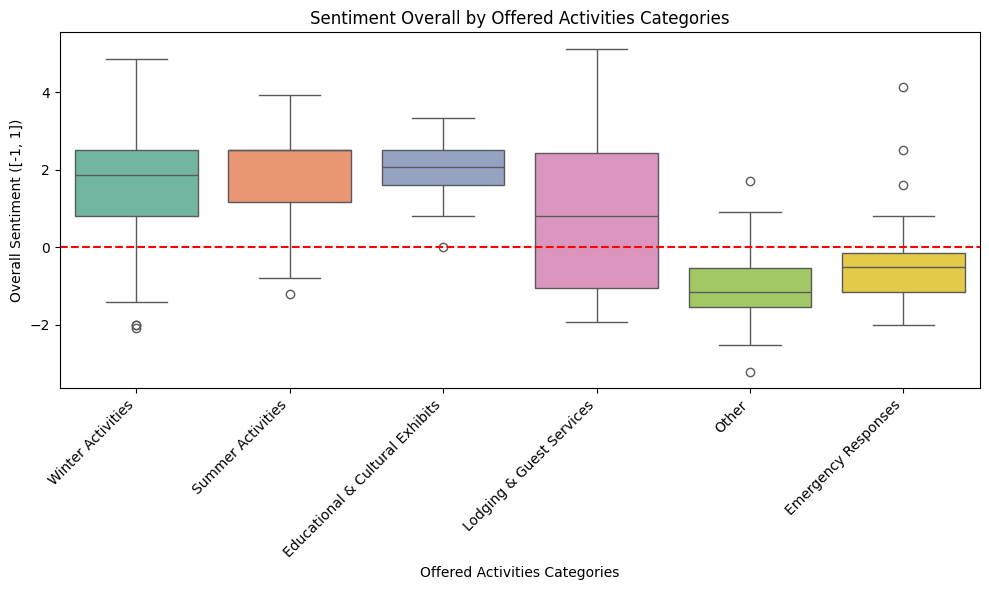

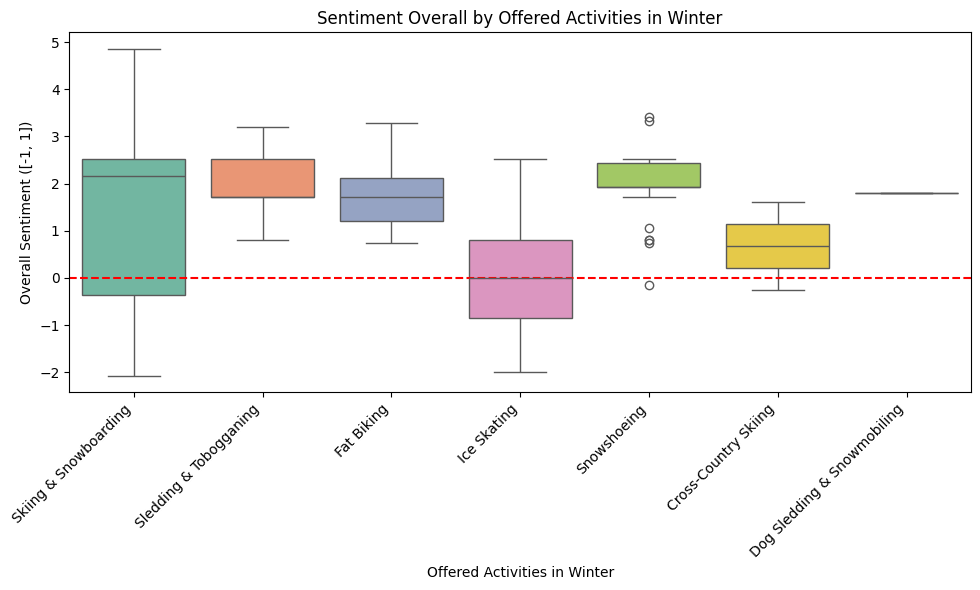

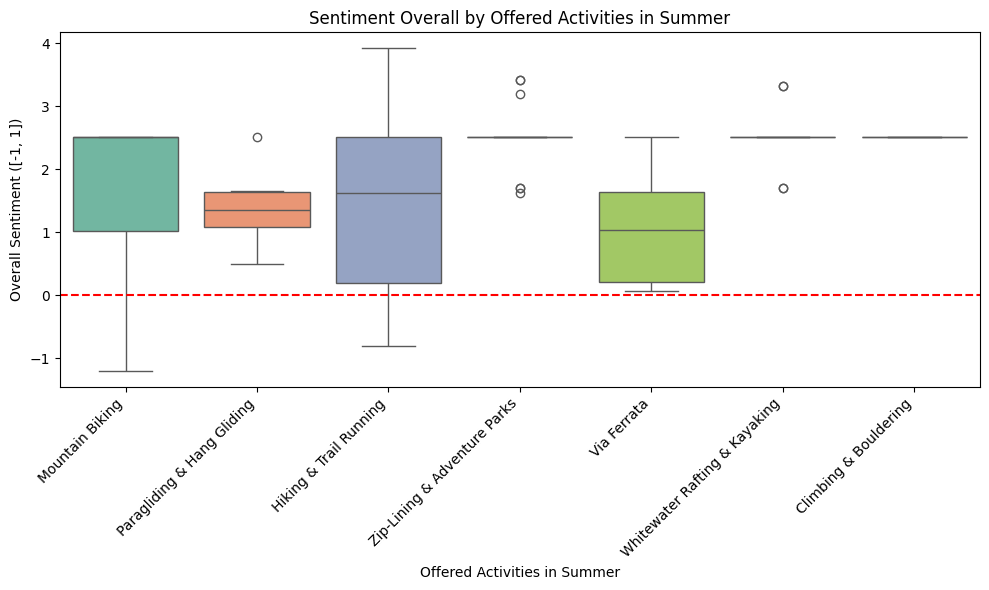

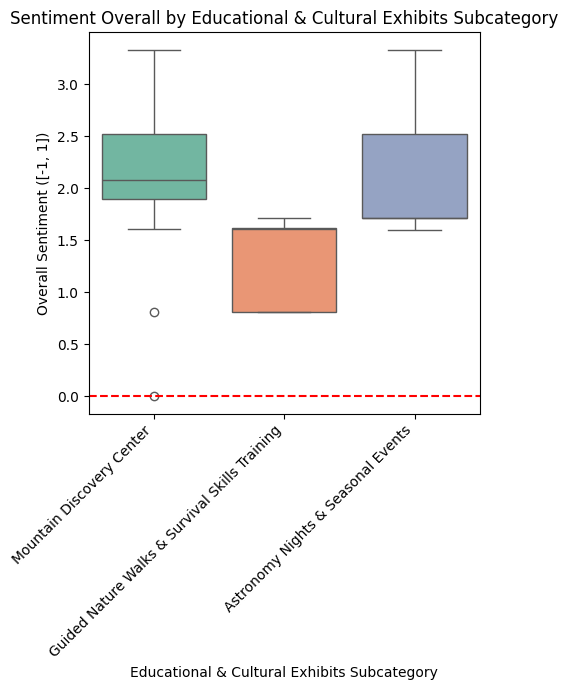

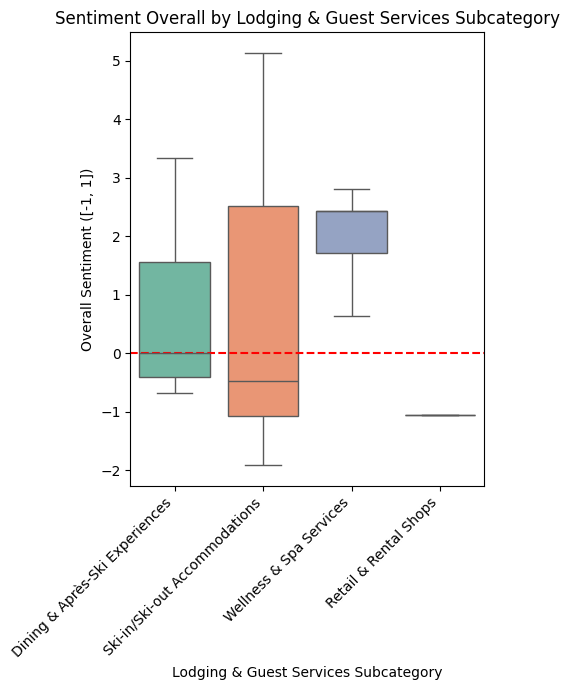

In [13]:
# For sentimental analysis, create a boxplot showing the distributions

# Function to create boxplots for sentiment by category or subcategory
def create_sentiment_boxplot(df, category_column, sentiment_column, title_prefix, hue_column=None, figsize=(10, 6)):
    unique_categories = df[category_column].unique()
    color_palette = sns.color_palette("Set2")[:len(unique_categories)]  # Ensure color palette size matches the number of categories

    plt.figure(figsize=figsize)
    ax = sns.boxplot(x=category_column, y=sentiment_column, data=df, palette=color_palette, hue=hue_column, legend=False)

    ax.set(xlabel=title_prefix, ylabel="Overall Sentiment ([-1, 1])")
    plt.title(f'Sentiment Overall by {title_prefix}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.axhline(y=0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

# Load data from Google Cloud Storage
bucket_name = "ubc-bolt-case"
blob_name = "reviews_final_model_results.csv"

storage_client = storage.Client(credentials=credentials)
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)
content = blob.download_as_text()

# Convert CSV to DataFrame
df = pd.read_csv(io.StringIO(content))

# 1. Create Sentiment vs. Broad Category Boxplot
create_sentiment_boxplot(df, 'broad_category', 'sentiment_overall', 'Offered Activities Categories')

# 2. Create Sentiment vs. Each Winter Activity Boxplot
winter_df = df[df['broad_category'] == 'Winter Activities']
create_sentiment_boxplot(winter_df, 'subcategory', 'sentiment_overall', 'Offered Activities in Winter', hue_column='subcategory')

# 3. Create Sentiment vs. Each Summer Activity Boxplot
summer_df = df[df['broad_category'] == 'Summer Activities']
create_sentiment_boxplot(summer_df, 'subcategory', 'sentiment_overall', 'Offered Activities in Summer', hue_column='subcategory')

# 4. Create Sentiment vs. Each Educational & Cultural Exhibits Boxplot
edu_df = df[df['broad_category'] == 'Educational & Cultural Exhibits']
create_sentiment_boxplot(edu_df, 'subcategory', 'sentiment_overall', 'Educational & Cultural Exhibits Subcategory', hue_column='subcategory', figsize=(5, 7))

# 5. Create Sentiment vs. Each Lodging & Guest Services Boxplot
lodge_df = df[df['broad_category'] == 'Lodging & Guest Services']
create_sentiment_boxplot(lodge_df, 'subcategory', 'sentiment_overall', 'Lodging & Guest Services Subcategory', hue_column='subcategory', figsize=(5, 7))

/tmp/ipykernel_19865/4252717818.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=broad_sentiment.index, x=broad_sentiment.values, palette="coolwarm")


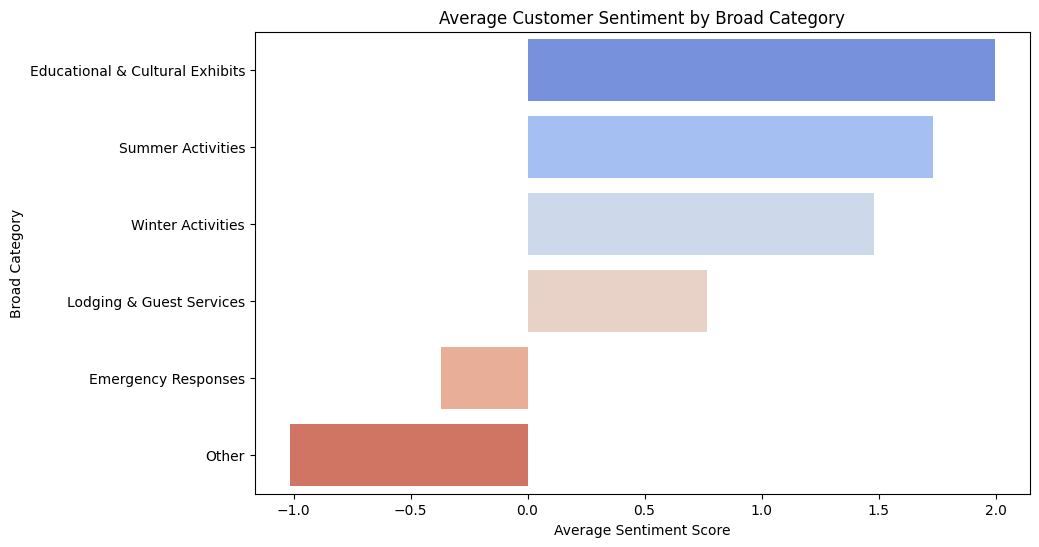

/tmp/ipykernel_19865/4252717818.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="broad_category", y="sentiment_overall", data=df, palette="viridis")


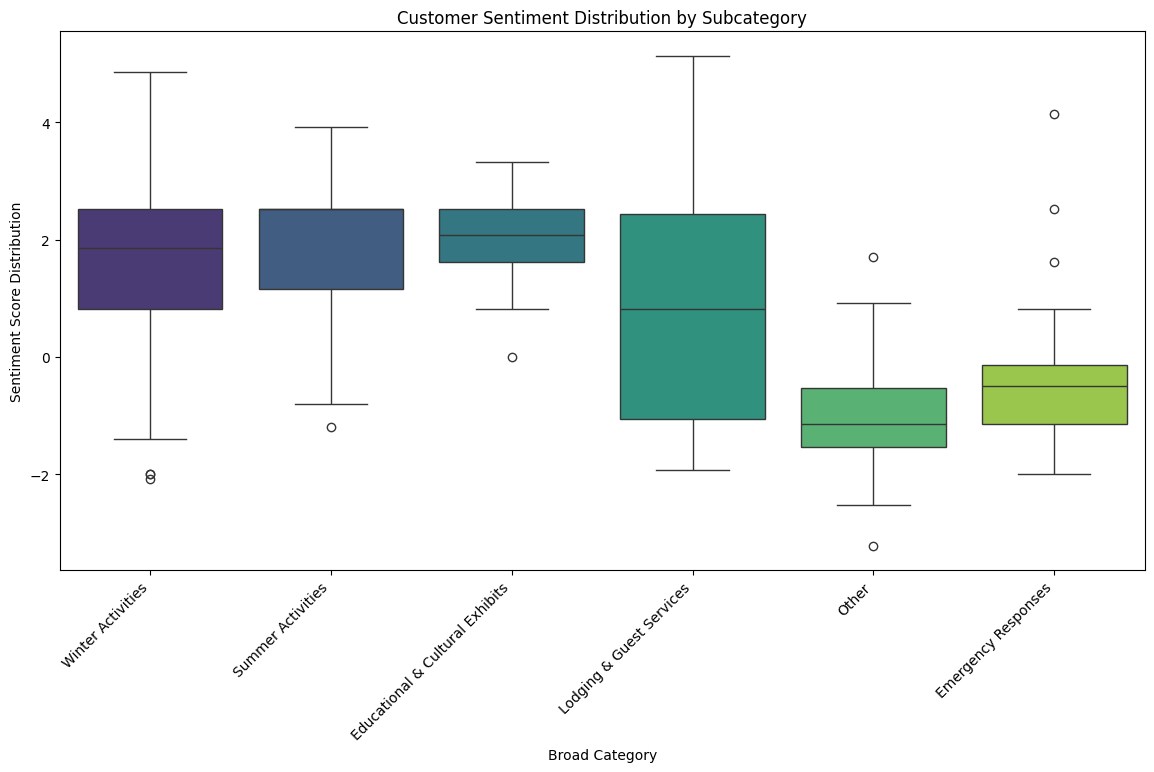

broad_category
Educational & Cultural Exhibits    1.995897
Summer Activities                  1.734706
Winter Activities                  1.482266
Lodging & Guest Services           0.768252
Emergency Responses               -0.372000
Other                             -1.015254
Name: sentiment_overall, dtype: float64

In [14]:
# Load CSV file from GCS
bucket_name = "ubc-bolt-case"
blob_name = "reviews_final_model_results.csv"

storage_client = storage.Client(credentials=credentials)
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)
content = blob.download_as_text()

# Convert CSV to DataFrame
df = pd.read_csv(io.StringIO(content))


# Broad Category Sentiment Analysis
broad_sentiment = df.groupby("broad_category")["sentiment_overall"].mean().sort_values(ascending=False)

# Plot Broad Category Sentiment (Horizontal Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(y=broad_sentiment.index, x=broad_sentiment.values, palette="coolwarm")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Broad Category")
plt.title("Average Customer Sentiment by Broad Category")
plt.show()

# Subcategory Sentiment Analysis - Boxplot for better clarity
plt.figure(figsize=(14, 7))
sns.boxplot(x="broad_category", y="sentiment_overall", data=df, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Broad Category")
plt.ylabel("Sentiment Score Distribution")
plt.title("Customer Sentiment Distribution by Subcategory")
plt.show()
broad_sentiment

In [15]:
data = {
    'Expense Category': ['Staff Salary', 'Ambulance Call', 'Equipment Maintenance'],
    'Percentage of Total Expenses': [73.2, 19.8, 7.0]
}

df_rev = pd.DataFrame(data)
df_rev

,Expense Category,Percentage of Total Expenses
0,Staff Salary,73.2
1,Ambulance Call,19.8
2,Equipment Maintenance,7.0


In [16]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.cloud import storage
import io

# Load CSV file from GCS
bucket_name = "ubc-bolt-case"
blob_name = "reviews_final_model_results.csv"

storage_client = storage.Client(credentials=credentials)
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)
content = blob.download_as_text()

# Convert CSV to DataFrame
df = pd.read_csv(io.StringIO(content))

# Define a custom stopwords list
custom_stopwords = set([
    "the", "and", "to", "a", "of", "in", "is", "it", "this", "that", "on", "for",
    "with", "as", "was", "but", "at", "by", "an", "be", "were", "or", "not", "from",
    "they", "had", "have", "you", "we", "are", "can", "if", "there", "so", "out",
    "about", "some", "one", "more", "which", "has", "all", "very", "them", "when",
    "what", "no", "just", "would", "like", "will", "up", "me", "my", "their", "our", "us"
])

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return " ".join(words)

# Dictionary to store topic modeling results
topic_results = {}

# Process each broad category
for category in df["broad_category"].unique():
    category_reviews = df[df["broad_category"] == category]["Review Text"].dropna()

    if category_reviews.empty:
        continue

    processed_reviews = category_reviews.apply(preprocess_text)

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(processed_reviews)

    # Extract top keywords
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()
    top_keywords = feature_array[np.argsort(tfidf_sums)[::-1]][:20]

    # Topic Modeling with LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(tfidf_matrix)

    # Extract topics
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_array[i] for i in topic.argsort()[-5:]]
        topic_keywords[f"Topic {topic_idx+1}"] = top_words

    # Store results in dictionary
    topic_results[category] = {
        "Top Keywords": top_keywords,
        "Identified Topics": topic_keywords
    }

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(topic_results, orient='index')

# Display results
results_df


,Top Keywords,Identified Topics
Winter Activities,"[trails, experience, winter, skiing, great, fu...","{'Topic 1': ['activities', 'lodge', 'better', ..."
Summer Activities,"[trails, experience, summer, views, mountain, ...","{'Topic 1': ['walks', 'great', 'hiking trails'..."
Educational & Cultural Exhibits,"[center, experience, mountain, mountain discov...","{'Topic 1': ['walk', 'astronomy', 'astronomy n..."
Lodging & Guest Services,"[resort, ski, lodge, great, mountain, perfect,...","{'Topic 1': ['staff peak', 'ski', 'truly', 'te..."
Other,"[staff, resort, food, overpriced, better, too,...","{'Topic 1': ['felt', 'beautiful', 'it', 'resor..."
Emergency Responses,"[remote, emergency, medical, remote location, ...","{'Topic 1': ['helicopter', 'respond', 'patrol'..."
